In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as pltticker
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier, VotingClassifier 
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.metrics import make_scorer
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as IPipeline
from xgboost import XGBClassifier
from joblib import parallel_backend
import pickle
import re
import dataframe_image as dfi

/home/joshua/anaconda3/envs/learn-env/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Configures axis and title labels
def configure_axislabels_and_title(ax, xlabel, ylabel, title):
    # Set fonts, padding, and fontsize for axis labels and title
    ax.set_xlabel(xlabel,
                  fontfamily = 'Arial',
                  fontsize = 24,
                  labelpad = 5)

    ax.set_ylabel(ylabel,
                  fontfamily = 'Arial',
                  fontsize = 24,
                  labelpad = 10)

    ax.set_title(title,
                 fontfamily = 'Arial',
                 fontsize = 32,
                 pad = 10)
    
    return None

In [3]:
# Configures ticklabels and tick parameters
def configure_ticklabels_and_params(ax):
    # Set label sizes and tick lengths
    ax.tick_params(axis = 'both',
                   which = 'major',
                   labelsize = 16,
                   length = 8,
                   width = 1)

    # Set font for tick labels on both axes
    for tick in ax.get_xticklabels():
        tick.set_fontname("Arial")

    for tick in ax.get_yticklabels():
        tick.set_fontname("Arial")
        
    return None

In [4]:
def evaluate_model(X_test, y_test, model):
    
    num_classes = len(y_test.value_counts())
    
    if type(model) == GridSearchCV:
        feature_names = model.best_estimator_.steps[0][1].transformers_[-1][1].get_feature_names()
        one_hot_col = model.best_estimator_.steps[0][1].transformers_[-1][-1]
        feature_importances = model.best_estimator_.steps[-1][-1].feature_importances_
    else:
        feature_names = model.steps[0][1].transformers_[-1][1].categories_[0]
        one_hot_col = model.steps[0][1].transformers_[-1][-1]
        if type(model.steps[-1][-1]) == LogisticRegression:
            feature_importances = model.steps[-1][-1].coef_[0]
        else:
            feature_importances = model.steps[-1][-1].feature_importances_
    
    
    y_pred_proba = model.predict_proba(X_test)
    y_pred = model.predict(X_test)

    if y_pred_proba.shape[1] == 2:
        y_pred_proba = y_pred_proba[:, 1]
    
    if num_classes > 2:
        auc = roc_auc_score(y_test, y_pred_proba, multi_class = 'ovo', average = 'weighted')
    else:
        auc = roc_auc_score(y_test, y_pred_proba)
    
    recalls = []
    precisions = []
    f1s = []
    
    for i in range(num_classes):
        recalls.append(class_k_recall(y_test, y_pred, k = i))
        precisions.append(class_k_precision(y_test, y_pred, k = i))
        f1s.append(class_k_f1(y_test, y_pred, k = i))
        
    accuracy = accuracy_score(y_test, y_pred)
    
    classification_frame = pd.DataFrame(np.array([recalls, precisions, f1s]).T,
                                        columns = ['recall', 'precision', 'f1'])
    
    classification_frame['accuracy'] = [accuracy] + [None] * (num_classes - 1)
    classification_frame['auc'] = [auc] + [None] * (num_classes - 1)
    
    for index, string in enumerate(feature_names):
        for i in range(len(one_hot_col)):
            feature_names[index] = re.sub(r'x{}'.format(i), one_hot_col[i], feature_names[index])
    
    feature_names = feature_names.tolist() + [x for x in X_test if x not in one_hot_col]
    
    
    
    feature_pairs = list(zip(feature_names, feature_importances))
    
    feature_frame = pd.DataFrame(feature_pairs, columns = ['feature', 'coefficient'])
    
    return classification_frame, feature_frame
    

In [5]:
def class_k_recall(y, y_pred, k = 0):
    pairs = list(zip(y, y_pred))
    num_of_variables = len(list(set(y)))
    tp = pairs.count((k, k))
    fn = 0
    
    for i in range(num_of_variables):
        if i == k:
            continue
        fn += pairs.count((k,i))
    
    return tp / (fn + tp)

In [6]:
def class_k_precision(y, y_pred, k = 0):
    pairs = list(zip(y, y_pred))
    num_of_variables = len(list(set(y)))
    tp = pairs.count((k, k))
    fp = 0
    
    for i in range(num_of_variables):
        if i == k:
            continue
        fp += pairs.count((i, k))
        
    return tp / (tp + fp)

In [7]:
def class_k_f1(y, y_pred, k = 0):
    recall = class_k_recall(y, y_pred, k)
    precision = class_k_precision(y, y_pred, k)
    
    return 2 * recall * precision / (recall + precision)

In [8]:
def class_k_acc(y, y_pred, k = 0):
    pairs = list(zip(y, y_pred))
    num_of_variables = len(list(set(y)))
    tp = pairs.count((k, k))
    miss = 0
    
    for i in range(num_of_variables):
        if i == k:
            continue
        miss += pairs.count((i, k)) + pairs.count((k, i)) + pairs.count((i,i))
        
    return tp / (tp + miss)

In [9]:
train_multi = pd.read_parquet('../data/cleaned/train_multi.parquet')
X_train_multi = train_multi.drop('classification', axis = 1)
y_train_multi = train_multi.classification
test_multi = pd.read_parquet('../data/cleaned/test_multi.parquet')
X_test_multi = test_multi.drop('classification', axis = 1)
y_test_multi = test_multi.classification
full_multi = pd.concat([train_multi, test_multi], axis = 0)

In [10]:
train_binary = pd.read_parquet('../data/cleaned/train_binary.parquet')
X_train_binary = train_binary.drop('disposition', axis = 1)
y_train_binary = train_binary.disposition
test_binary = pd.read_parquet('../data/cleaned/test_binary.parquet')
X_test_binary = test_binary.drop('disposition', axis = 1)
y_test_binary = test_binary.disposition
full_binary = pd.concat([train_binary, test_binary], axis = 0)

In [11]:
with open('../data/models/binary/binary_base_logistic.pickle', 'rb') as f:
    base_binary_model = pickle.load(f)

base_binary_class_report, base_binary_features = evaluate_model(X_test_binary, y_test_binary, base_binary_model)
base_binary_features.coefficient = base_binary_features.coefficient.abs()

In [12]:
with open('../data/models/binary/binary_xgboost.pickle', 'rb') as f:
    best_binary_model = pickle.load(f)

best_binary_class_report, best_binary_features = evaluate_model(X_test_binary, y_test_binary, best_binary_model)
best_binary_features.coefficient = best_binary_features.coefficient.abs()

In [13]:
with open('../data/models/multi/multi_base_tree.pickle', 'rb') as f:
    base_multi_model = pickle.load(f)

base_multi_class_report, base_multi_features = evaluate_model(X_test_multi, y_test_multi, base_multi_model)
base_multi_features.coefficient = base_multi_features.coefficient.abs()

In [14]:
with open('../data/models/multi/multi_xgboost.pickle', 'rb') as f:
    best_multi_model = pickle.load(f)

best_multi_class_report, best_multi_features = evaluate_model(X_test_multi, y_test_multi, best_multi_model)
best_multi_features.coefficient = best_multi_features.coefficient.abs()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


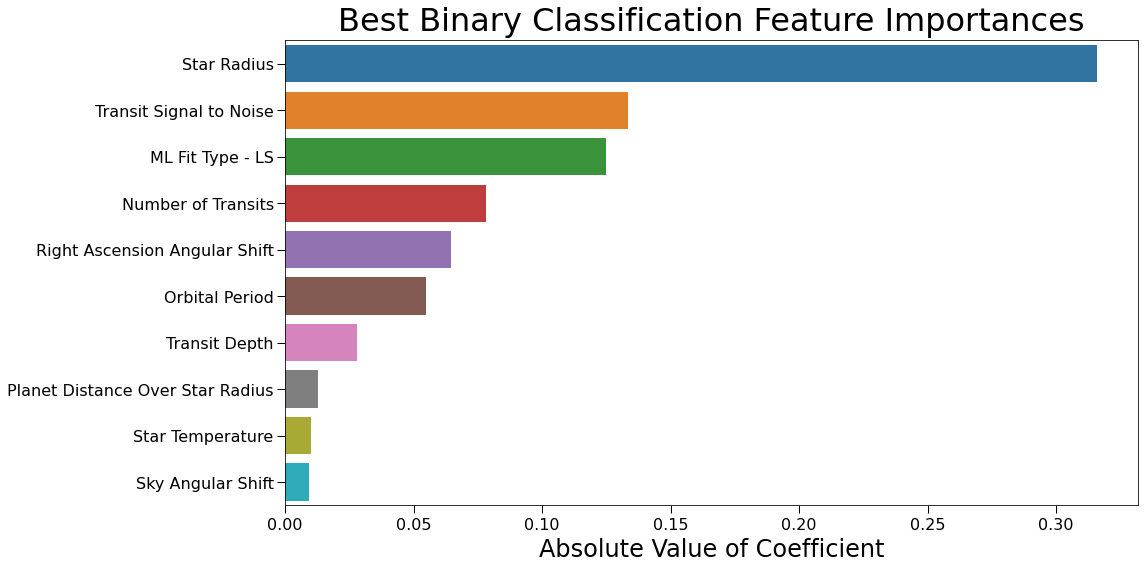

In [15]:
fig, ax = plt.subplots(figsize = (16, 8))

top_10_features = best_binary_features.nlargest(10, 'coefficient')

sns.barplot(data = top_10_features,
            y = 'feature', x = 'coefficient', orient = 'h', ax = ax);

configure_axislabels_and_title(ax, 'Absolute Value of Coefficient',
                               None, 'Best Binary Classification Feature Importances')

feature_labels = ['Star Radius', 'Transit Signal to Noise', 'ML Fit Type - LS', 'Number of Transits',
                  'Right Ascension Angular Shift', 'Orbital Period', 'Transit Depth',
                  'Planet Distance Over Star Radius', 'Star Temperature', 'Sky Angular Shift']

configure_ticklabels_and_params(ax)

ax.set_yticklabels(feature_labels);

plt.tight_layout()

plt.savefig('../images/best_binary_feature_importances.png')

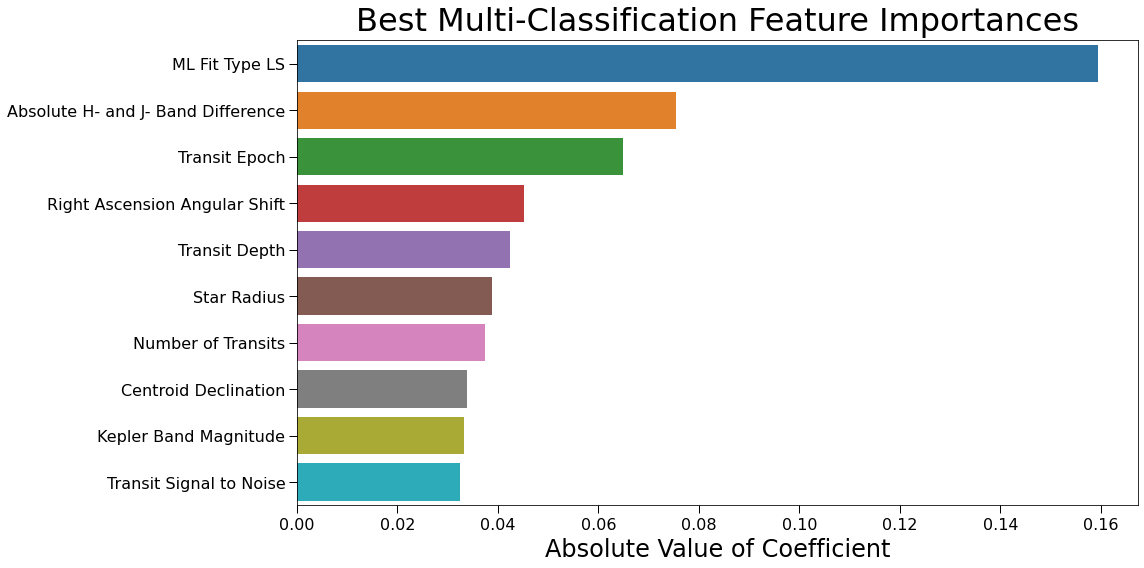

In [16]:
fig, ax = plt.subplots(figsize = (16, 8))

top_10_features = best_multi_features.nlargest(10, 'coefficient')

sns.barplot(data = top_10_features,
            y = 'feature', x = 'coefficient', orient = 'h', ax = ax);

configure_axislabels_and_title(ax, 'Absolute Value of Coefficient',
                               None, 'Best Multi-Classification Feature Importances')

feature_labels = ['ML Fit Type LS', 'Absolute H- and J- Band Difference', 'Transit Epoch',
                  'Right Ascension Angular Shift', 'Transit Depth', 'Star Radius', 'Number of Transits',
                  'Centroid Declination', 'Kepler Band Magnitude', 'Transit Signal to Noise']

configure_ticklabels_and_params(ax)

ax.set_yticklabels(feature_labels);

plt.tight_layout()

plt.savefig('../images/best_multi_feature_importances.png')

In [17]:
full_binary.columns

Index(['ml_fittype', 'num_of_objects_around_star', 'right_ascension',
       'declination', 'g_band_mag', 'r_band_mag', 'i_band_mag', 'z_band_mag',
       'j_band_mag', 'h_band_mag', 'k_band_mag', 'kepler_band_mag',
       'num_of_transits', 'max_single_event_stat', 'max_multi_event_stat',
       'odd_even_depth_stat', 'limb_dark_co4', 'limb_dark_co3',
       'limb_dark_co2', 'limb_dark_co1', 'transit_signal_to_noise',
       'transit_epoch', 'planet_radius_earth', 'orbit_semimajor_axis',
       'impact', 'transit_duration', 'transit_depth', 'orbital_period',
       'planet_star_radius_ratio', 'planet_star_distance_radius',
       'inclination', 'planet_temp', 'star_temp', 'star_surface_gravity',
       'star_metallicity', 'star_radius', 'star_mass',
       'flux_weight_offset_sig', 'centroid_right_ascension',
       'centroid_declination', 'centroid_right_ascension_offset',
       'centroid_declination_offset', 'planet_star_right_ascension_offset',
       'planet_star_declination_offs

In [18]:
columns_to_plot = ['transit_depth', 'star_radius', 'num_of_transits',
                   'transit_signal_to_noise', 'orbital_period']

In [19]:
def plot_boxplots(frame_targets, column):
    num_frames = len(frame_targets)
    
    fig, ax = plt.subplots(1, num_frames, figsize = (8 * num_frames, 8))
    
    plt.tight_layout(pad = 4.0)
    
    for index, (frame, target) in enumerate(frame_targets):
        if num_frames != 1:
            axis = ax[index]
        else:
            axis = ax
        
        sns.boxplot(data = frame,
                    x = frame[column],
                    y = frame[target],
                    orient = 'h',
                    ax = axis);
        
    return fig, ax

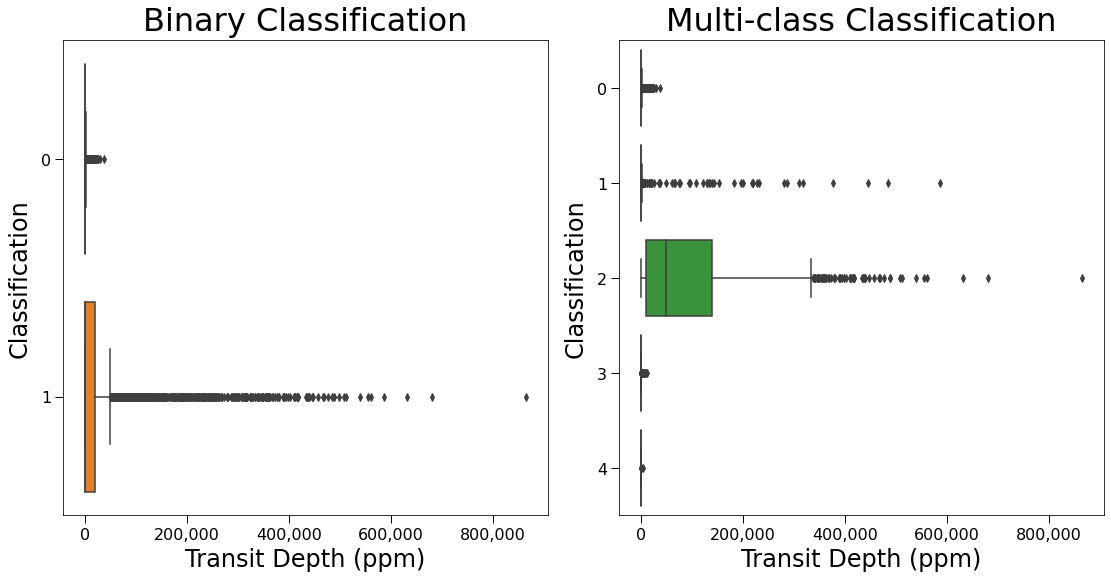

In [20]:
fig, ax = plot_boxplots([(full_binary, 'disposition'), (full_multi, 'classification')], 'transit_depth')

for axis in ax:
    configure_axislabels_and_title(axis, 'Transit Depth (ppm)',
                               'Classification', None)
    axis.get_xaxis().set_major_formatter(pltticker.FuncFormatter(lambda x, p: format(int(x),',')))
    configure_ticklabels_and_params(axis)

ax[0].set_title('Binary Classification', fontfamily = 'Arial', fontsize = 32, pad = 10);
ax[1].set_title('Multi-class Classification', fontfamily = 'Arial', fontsize = 32, pad = 10);

plt.savefig('../images/transit_depth_boxplots.png')

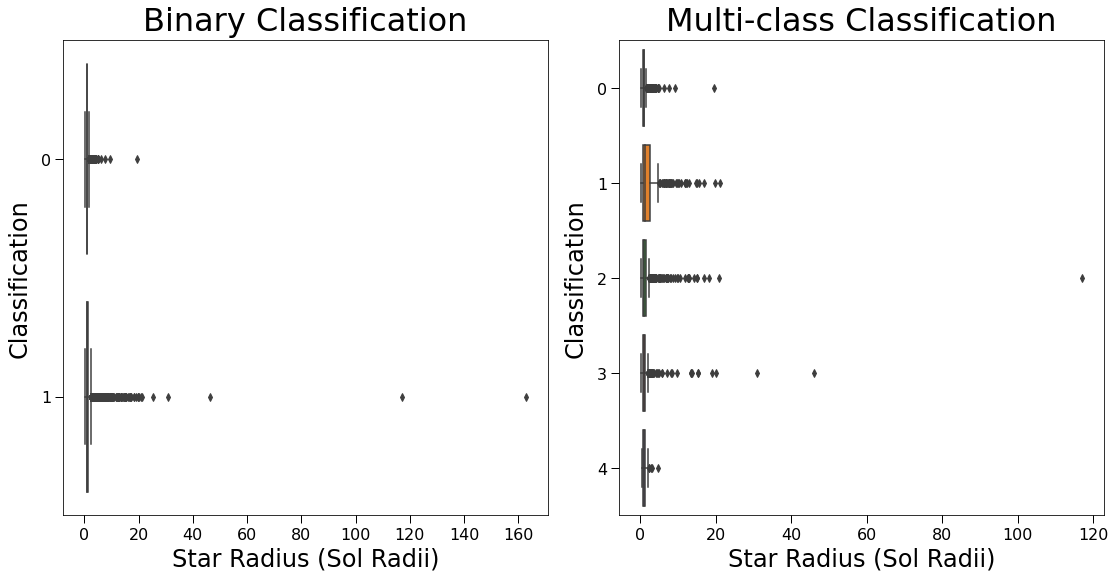

In [21]:
fig, ax = plot_boxplots([(full_binary, 'disposition'), (full_multi, 'classification')], 'star_radius')

for axis in ax:
    configure_axislabels_and_title(axis, 'Star Radius (Sol Radii)',
                               'Classification', None)
    axis.get_xaxis().set_major_formatter(pltticker.FuncFormatter(lambda x, p: format(int(x),',')))
    configure_ticklabels_and_params(axis)

ax[0].set_title('Binary Classification', fontfamily = 'Arial', fontsize = 32, pad = 10);
ax[1].set_title('Multi-class Classification', fontfamily = 'Arial', fontsize = 32, pad = 10);

plt.savefig('../images/star_radius_boxplots.png')

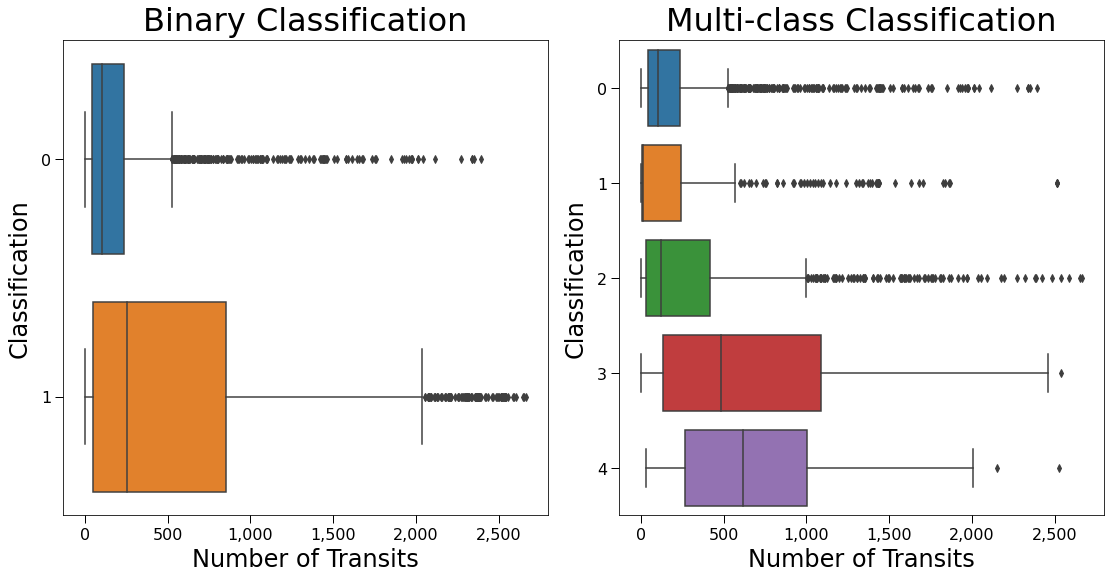

In [22]:
fig, ax = plot_boxplots([(full_binary, 'disposition'), (full_multi, 'classification')], 'num_of_transits')

for axis in ax:
    configure_axislabels_and_title(axis, 'Number of Transits',
                               'Classification', None)
    axis.get_xaxis().set_major_formatter(pltticker.FuncFormatter(lambda x, p: format(int(x),',')))
    configure_ticklabels_and_params(axis)

ax[0].set_title('Binary Classification', fontfamily = 'Arial', fontsize = 32, pad = 10);
ax[1].set_title('Multi-class Classification', fontfamily = 'Arial', fontsize = 32, pad = 10);

plt.savefig('../images/num_of_transits_boxplots.png')

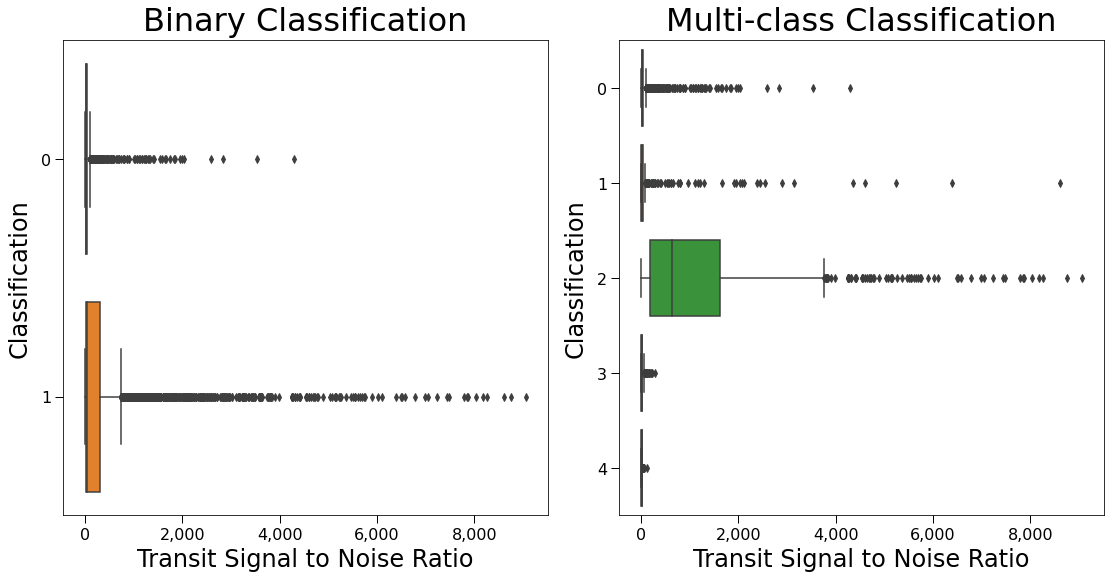

In [23]:
fig, ax = plot_boxplots([(full_binary, 'disposition'), (full_multi, 'classification')], 'transit_signal_to_noise')

for axis in ax:
    configure_axislabels_and_title(axis, 'Transit Signal to Noise Ratio',
                               'Classification', None)
    axis.get_xaxis().set_major_formatter(pltticker.FuncFormatter(lambda x, p: format(int(x),',')))
    configure_ticklabels_and_params(axis)

ax[0].set_title('Binary Classification', fontfamily = 'Arial', fontsize = 32, pad = 10);
ax[1].set_title('Multi-class Classification', fontfamily = 'Arial', fontsize = 32, pad = 10);

plt.savefig('../images/transit_signal_to_noise_boxplots.png')

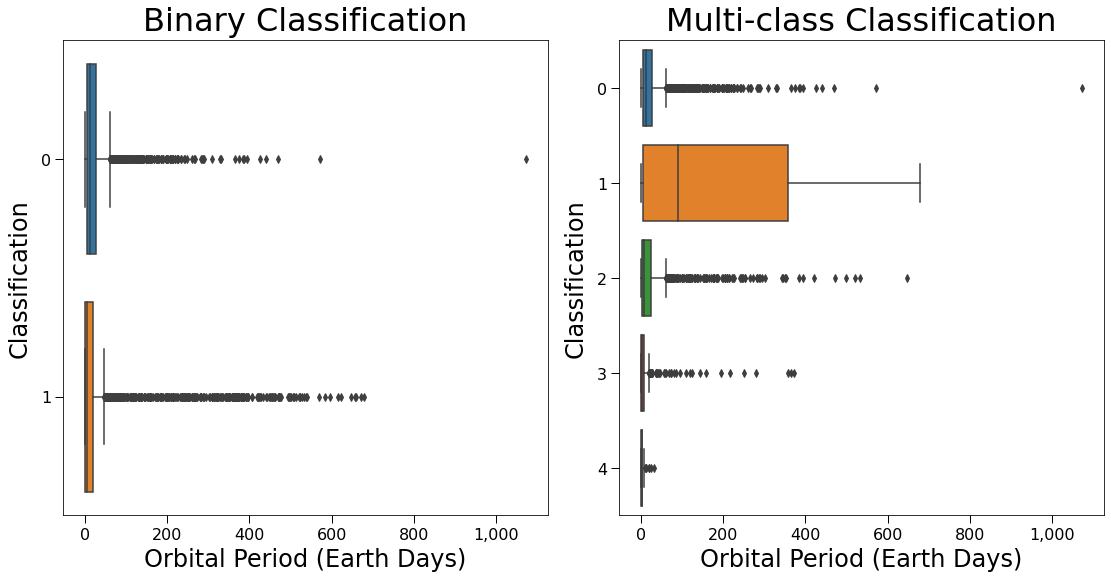

In [24]:
fig, ax = plot_boxplots([(full_binary, 'disposition'), (full_multi, 'classification')], 'orbital_period')

for axis in ax:
    configure_axislabels_and_title(axis, 'Orbital Period (Earth Days)',
                               'Classification', None)
    axis.get_xaxis().set_major_formatter(pltticker.FuncFormatter(lambda x, p: format(int(x),',')))
    configure_ticklabels_and_params(axis)

ax[0].set_title('Binary Classification', fontfamily = 'Arial', fontsize = 32, pad = 10);
ax[1].set_title('Multi-class Classification', fontfamily = 'Arial', fontsize = 32, pad = 10);

plt.savefig('../images/orbital_period_boxplots.png')

In [26]:
dfi.export(base_binary_class_report, '../images/base_binary_class_report.png')
dfi.export(best_binary_class_report, '../images/best_binary_class_report.png')
dfi.export(base_multi_class_report, '../images/base_multi_class_report.png')
dfi.export(best_multi_class_report, '../images/best_multi_class_report.png')